# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. Σύστημα συστάσεων βασισμένο στο περιεχόμενο - σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [1]:
from io import StringIO#εισάγουμε τις βιβλιοθήκες που θα χρειαστούμε
import requests
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
!pip install --upgrade numpy

Requirement already up-to-date: numpy in /home/nbuser/anaconda2_501/lib/python2.7/site-packages


In [1]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_e83bb2ed70e300a3a681580fec6a7d42c6cd8eb2','domain': {'id': 'dd180082cfbb4aba93677ea2bbc9d7ff'},
            'password': 'y]333V2!.D=?Blh='}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

# Your data file was loaded into a StringIO object and you can process the data.
# Please read the documentation of pandas to learn more about your possibilities to load your data.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html
df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'movieDBe.csv'), sep='\t',  header=None, quoting=3)
df_data_2 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'seedb.csv'),  header=None)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών ως εξής: κάθε ομάδα μπορεί να βρει [εδώ](https://goo.gl/4TuDcA) τον μοναδικό  αριθμό της `team_seed_number` από 1 έως 99. Το data frame `df_data_2` έχει 100 γραμμές και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. Στο επόμενο μπλοκ αλλάξτε τη μεταβλητή `team_seed_number` με τον αριθμό της ομάδας σας και τρέξτε τον κώδικα.

In [2]:
# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 17 #Όπως βρέθηκε στο αντίστοιχο site
my_index = df_data_2.iloc[team_seed_number,:].values
titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=100` θα γράψουμε `print corpus[100]`.

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="50%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [35]:
vectorizer = TfidfVectorizer()#default parameters
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)
print corpus_tf_idf.shape

(5000, 48315)


Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ δεν είναι βελτιστοποιημένη. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν δραματική επίδραση στην ποιότητα των συστάσεων και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη διαστατικότητα των δεδομένων. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους χρόνους εκπαίδευσης, ιδιαίτερα στη δεύτερη εφαρμογή.

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται.

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (4, 5 ή και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης `content_recommender(529,3)`.

## &spades; Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
from sklearn.externals import joblib  
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα. Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [5]:
joblib.dump(titles, 'titles.pkl') 
joblib.dump(categories, 'categories.pkl') 
joblib.dump(catbins, 'catbins.pkl')
joblib.dump(summaries, 'summaries.pkl')
joblib.dump(corpus, 'corpus.pkl') 

['corpus.pkl']

In [2]:
titles = joblib.load('titles.pkl')
categories = joblib.load('categories.pkl')
catbins = joblib.load('catbins.pkl')
summaries = joblib.load('summaries.pkl')
corpus = joblib.load('corpus.pkl')


Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [21]:
ls

Exercise_2_Ekfwnisi.ipynb  catbins.pkl     corpus_tf_idf.pkl  summaries.pkl
Exercise_2_Working.ipynb   categories.pkl  som.pkl            titles.pkl
README.md                  corpus.pkl      somKmeans.pkl


In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy import argsort


 εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)

In [4]:
def content_recommender( target_movie,max_recommendations ):
    cos_values=np.zeros(5000)#αρχικοποίηση στο μηδέν
    print "*** Target movie",target_movie,"***"#το id της ταινίας στόχου
    print "Title:",titles[target_movie][0]#ο τίτλος της ταινίας
    print "Summary:",corpus[target_movie]#Η περιγραφή της
    print "Genres:",categories[target_movie][0]#οι κατηγορίες στις οποίες ανήκει
    print "***",max_recommendations,"most related movies based on content ***"
    for movie in range(0,5000):
        cos_values[movie]=cosine_similarity(corpus_tf_idf[target_movie],corpus_tf_idf[movie])#συγκρίνουμε την ταινία στόχο με όλες τις υπόλοιπες με την ομοιότητα συνημιτόνου        
    cos_val_desc=(-cos_values).argsort()[:5000]#τις διατάσσουμε σε φθίνουσα σειρά 
    cos_val_max=cos_val_desc[1:max_recommendations+1]#αφαιρούμε την πρώτη που είναι ο ευατός της
    for recommendations in range(1,max_recommendations+1):#για όσα recommendations ζητήθηκαν 
        print cos_values[cos_val_max[recommendations-1]]#εκτυπώνουμε ομοιότητα συνημιτόνου
        print "*** Recommended movie No.",recommendations,"***"#ποίο recommendation είναι
        print "Movie ID: ",cos_val_max[recommendations-1]#το id της
        print "Title:",titles[cos_val_max[recommendations-1]][0]#τον τίτλο της
        print "Summary:",corpus[cos_val_max[recommendations-1]]#την περιγραφή της
        print "Genres:",categories[cos_val_max[recommendations-1]][0]#τις κατηγορίες στις οποίες ανήκει
    return 0;

## Παραπάνω έχει ολοκληρωθεί η συνάρτηση content_recommender
Στη συνέχεια θα ασχοληθούμε με την βελτιστοποίηση της vectorizer()

In [6]:
tempdata = ' '.join([word for word in '~~~~'.join(corpus).replace('/',' ').replace('-',' ').split() if len(word)>2]).split('~~~~')
#χρησιμοποιούμε την εντολή που χρησιμοποιήθηκε και στο άσκηση του lab 6 για να αφαιρέσουμε επιπλέον χαρακτήρες που δεν έχουν ενδιαφέρον

In [7]:
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [8]:
nltk.download("all-corpora") #διότι μας έβγαζε error "Resource u'corpora/wordnet' not found."

[nltk_data] Downloading collection u'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to
[nltk_data]    |     /home

[nltk_data]    | Downloading package udhr to /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/udhr.zip.
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/udhr2.zip.
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/unicode_samples.zip.
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    | Downloading package verbnet to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/verbnet.zip.
[nltk_data]    | Downloading package webtext to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/webtext.zip.
[nltk_data]    | Downloading package wordnet to
[nltk_data]    |     /home/nbuser/nltk_data...
[nltk_data]    |   Unzipping corpora/wordnet.zip.
[nltk_data]    | Downloading packa

True

In [9]:
nltk.download("punkt")#διότι μας έβγαζε error "Resource u'punkt' not found."

[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
vectorizer_new = TfidfVectorizer(max_df=0.5, min_df=33,stop_words='english',tokenizer=LemmaTokenizer())#εφαρμόζουμε Lemmatize,αφαιρούμε stop words και εφαρμόζουμε max και mid df
corpus_tf_idf = vectorizer_new.fit_transform(tempdata)#εφαρμόζουμε την vectorizer
print corpus_tf_idf.shape#βλέπουμε τη διάσταση του corpus_tf_idf για να έχουμε εικόνα του πόσες περιεχόμενο αφαιρέθηκε με την vectorizer

(5000, 2972)


/home/nbuser/anaconda2_501/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Το max_df αφορά συχνότητα εμφάνισης λέξης στα 5000 κείμενα. Άρα, max_df=0.05=0.05*5000=250 κείμενα.

Το αρχικό shape του corpus_tf_idf ήταν (5000, 48315)
21971 gia max=0.99,min=2
21968 gia max=0.5,min=2
21936 gia max=0.2,min=2,
21846 gia max=0.1,min=2,
16293 gia max=0.1,min=3,


In [85]:
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') #αποθηκεύουμε το corpus_tf_idf

['corpus_tf_idf.pkl']

In [6]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

Στο παρακάτω παράδειγμα,παρατηρούσαμε ότι για παραμέτρους "max_df=0.05, min_df<31" εμφανίζονταν κείμενα που είχαν πολύ συχνά τη λέξη "Han" ή "Hans"(που ισοδυναμούν λόγω του LemmaTokenizer), με αποτέλεσμα να μην υπάρχει σχέση ανάμεσα τους.
Για min_df=31 η λέξη αυτή αφαιρέθηκε και εμφανίστηκαν πιο σχετικά κείμενα.

Βελτιστο το 0.2,31,εμφανισε 2135,2506,2576,429,4714, ομοίως και για 0.5,33 εμφανισε 2135,1)429,2)2576,3)2506,4)4714

## Σχολιασμός μεθοδολογίας και προβληματισμών και παρουσίαση 10 ταινιών

Γενικά παρατηρήσαμε ορισμένα προβλήματα που κάνουν δύσκολη την κατηγοριοποίηση των ταινιών με χρήση του cosine simularity . Ένα από αυτά ήταν το γεγονός ότι άλλες ταινίες έχουν πολύ μικρή περιγραφή(1 έως 3 γραμμές) ενώ άλλες είναι κείμενα ολόκληρα. Ως αποτέλεσμα μπορεί ταινίες που μπορεί πραγματικά να είναι όμοιες να μην ταιριάζονται λόγω έλλειψης πληροφορίας, ή και ταινίες που είναι τελείως διαφορετικές να ταιριάζονται επειδή οι λίγες (και μη χαρακτηριστικές) λέξεις του μικρού κειμένου υπάρχουν και στο μεγάλο κείμενο. Ένα άλλο πρόβλημα που παρατηρήσαμε είναι ότι διαφορετικές ταινίες μπορεί να ταιριαστούν λόγω μιας συχνά εμφανιζόμενης λέξης και στις δυο περιγραφές, όπως π.χ ένα όνομα (βλέπε Jesus στην ταινία Passion of the Christ). 

Όσον αφορά την επιλογή των παραμέτρων του Vectorizer έχουμε τα εξής. Οι παράμετροι που χρησιμοποιήσαμε αρχικά ήταν οι stop_words(=english),LemmaTokenizer(όπως κάναμε και στο Lab6),max_df,min_df. Η πρώτη παράμετρος είναι απαραίτητη και σταθερή. Στην δεύτερη τίθεται το θέμα για το αν θα τη χρησιμοποιήσουμε ή όχι. Κάνοντας πειραματισμούς σε διάφορες ταινίες είδαμε ότι ποτέ δε χειροτέρευε το αποτέλεσμα. Τις περισσότερες φορές δεν επέφερε αλλαγή αλλά υπήρχαν περιπτώσεις που βοηθούσε στο ταίριασμα, οπότε αποφασίσαμε να την κρατήσουμε. Όσον αφορά το max_df παρατηρήσαμε ότι μεταβολή της τιμής του απο 0.9 σε 0.2 μείωνε τη διάσταση των λέξεων μόνο κατά 40 περίπου λέξεις στο τεράστιο πλήθος των 48000 περίπου που ήταν αρχικά. Οπότε παρατηρήσαμε ότι μεταβολή της παραμέτρου αυτής ήταν λίγο πολύ ανούσια.

Το κεντρικό ενδιαφέρον το είχε η παράμετρος min_df. Αυτήν αρχικά την είχαμε σε χαμηλές τιμές (από 3 έως 5). Από 4 έως 5 η διάσταση είχε μειωθεί στις 16000 περίπου αλλά δε βλέπαμε ουσιαστική διαφορά. Πειραματίζοντας κατόπιν σε υποσχόμενες ταινίες όπως το Star Wars είδαμε ότι αρχικά οι 2 στις 4 προτεινόμενες ταινίες ήταν πολύ σχετικές ενώ οι άλλες δύο άσχετες. Με σταδιακή αύξηση του min_df εξετάζαμε ξανά την έξοδο και παρατηρήσαμε ότι οι προτεινόμενες ταινίες άλλαζαν και γίνονταν όλες καλές από 32 και μετά. Επιλέγοντας έτσι την τιμή 33 πήγαμε και σε άλλα παραδείγματα και είδαμε και εκεί ικανοποιητικά αποτελέσματα.

   ## Παραδείγματα 10 ταινιών με πολύ ικανοποιητικές εξόδους(για max_recommendations=4)

    1)Movie ID:1331,Title:Sanam Bewafa.
    Recommendations:Raja Desingu,Aithe,Noorie,Junoon.
    Κοινό χαρακτηριστικό όλων αυτών είναι ότι είναι ινδικές ταινίες του Bollywood.

    2)Movie ID:1637,Title:Coonskin.
    Recommendations:Winnie the Pooh:Seasons of Giving,Mexico,Hyde and Hare,Hiawatha's Rabbit Hunt.
    Κοινό χαρακτηριστικό όλων αυτών ήταν ότι πρόκεται για ταινίες με κινούμενα σχέδια, παιδικές/οικογενειακές ταινίες.

    3)Movie ID:1995,Title:Flamenco.
    Recommendations:Winnie the Pooh:The Tango Lesson,Dance with Me,Lola Montes,Clean Pastures.
    Κοινά χαρακτηριστικά αυτών των ταινιών είναι η μουσική και ο χορός (η τελευταία είναι κινούμενο σχέδιο με αρκετούς
    χαρακτήρες να είναι μουσικοί).

    4)Movie ID:2135,Title: Star Wars Episode VI: Return of the Jedi.
    Recommendations:i)Something, Something, Something Dark Side,ii) Star Wars Episode III: Revenge of the Sith,
    iii)Soldier Boyz,iv)Lego Star Wars: Bombad Bounty.
    Τα κοινά χαρακτηστικά της ταινίας με τις ii),iv) είναι προφανή. Η i) είναι ταίνια κινουμένων σχεδίων με 
    διαστημόπλοια και η iii) είναι και αυτή ταίνιες δράσης και περιπέτειας.

    5)Movie ID:2382,Title: Lifeforce.
    Recommendations:i)The Breed,ii) The Thirst,iii)From Dusk Till Dawn 3: The Hangman's Daughter,
    iv)Lost Boys: The Thirst.Όλες αυτές οι ταινίες είναι σχετικές με βρικόλακες και αποτελούν ταινίες τρόμου.

    6)Movie ID:2798,Title: Invasion of the Saucer Men.
    Recommendations:i)Earth vs. the Flying Saucers,ii)AVPR: Aliens vs Predator - Requiem,iii)Earthbound,
    iv)Dreamcatcher.
    Όλες αυτές οι ταινίες είναι σχετικές με εξωγήινους. Η ii) είναι ταινία τρόμου με τέρατα, ενώ η iii) είναι 
    animation και family film. Ναι μεν διαφορετικές ταινίες, αλλά επειδή η λέξη alien αποκτάει μεγάλη βαρύτητα επειδή 
    εμφανίζεται συχνά έχουν ταιριαστεί μαζί.

    7)Movie ID:3909,Title: Cocaine Cowboys.
    Recommendations:i)Harley Davidson and the Marlboro Man,ii)Tiger Island,iii)True Romance,iv)Dum Maaro Dum.
    Όλες αυτές οι ταινίες έχουν κοινό στοιχείο το έγκλημα,τα ναρκωτικά και τη δράση.

    8)Movie ID:4000,Title: The Disappeared.
    Recommendations:i)War of the Gargantuas,ii)The Buccaneers,iii)Jumping Ship,iv)A Shine of Rainbows.
    Όλες αυτές οι ταινίες έχουν κοινό στοιχείο ναυάγια και πλοία.

    9)Movie ID:4260,Title: Desperate Journey.
    Recommendations:i)Jungle Drums,ii)Line of Demarcation,iii)Hitler, Beast of Berlin,iv)The Goose Steps Out.
    Όλες αυτές οι ταινίες έχουν κοινό στοιχείο τους Ναζί, άλλες με ιστορικό περιεχόμενο,άλλη ως κινούμενο σχέδιο και 
    άλλη ως κωμωδία.

    10)Movie ID:4871,Title:Franz Liszt. Dreams of love.
    Recommendations:i)Pianomania,ii)Swarabhishekam,iii)Shakalaka Boom Boom,iv)Young Man with a Horn.
    Όλες αυτές οι ταινίες έχουν κοινό στοιχείο τη μουσική, άλλες ως δράμα, άλλες ως βιογραφία, άλλες ως ντοκιμαντέρ.

# Εφαρμογή 2.  Σημασιολογική απεικόνιση της συλλογής ταινιών με χρήση SOM
<img src="http://visual-memory.co.uk/daniel/Documents/intgenre/Images/film-genres.jpg" width="35%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` ως επιπλέον στήλες (χαρακτηριστικά). Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [11]:
def build_final_set(doc_limit = 5000):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return final_set

In [12]:
final_set = build_final_set()

In [13]:
print final_set.shape#παρατηρούμε τις διαστάσεις του τελικού set
print catbins.shape

(5000, 3294)
(5000, 322)


Μπορείτε να εξετάστε αργότερα αν περαιτέρω προεπεξεργασία του `final_set` έχει επίδραση στην ποιότητα του χάρτη SOM και του clustering.

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Πρόκειται για μια σύγχρονη και βελτιστοποιημένη υλοποίηση των SOM, παραλληλοποιημένη για CPU και GPU. Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [14]:
!pip install somoclu
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

    100% |################################| 6.2MB 184kB/s eta 0:00:01
  Running setup.py bdist_wheel for somoclu ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/84/f2/e0/7914b2bf855557497631ec8e3366d1fd0ca4e95ae25f3536e0
Successfully built somoclu


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.

In [16]:
n_rows, n_columns = 30, 30#εδώ επιλέγουμε τις παραμέτρους που θέλουμε να περάσουμε στην εκπαίδευση του somoclu
som = somoclu.Somoclu(n_columns, n_rows)
%time som.train(data=final_set,epochs=100)

CPU times: user 1h 30s, sys: 2.79 s, total: 1h 32s
Wall time: 30min 31s


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.

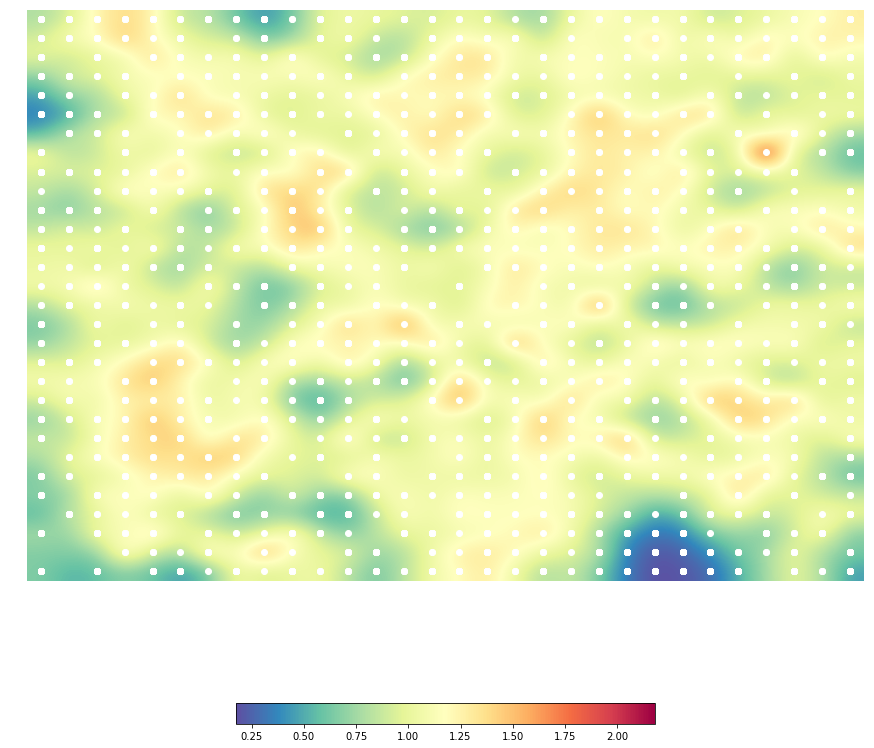

<module 'matplotlib.pyplot' from '/home/nbuser/anaconda2_501/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [19]:
som.view_umatrix(bestmatches=True,figsize=(15, 15),colorbar=True)

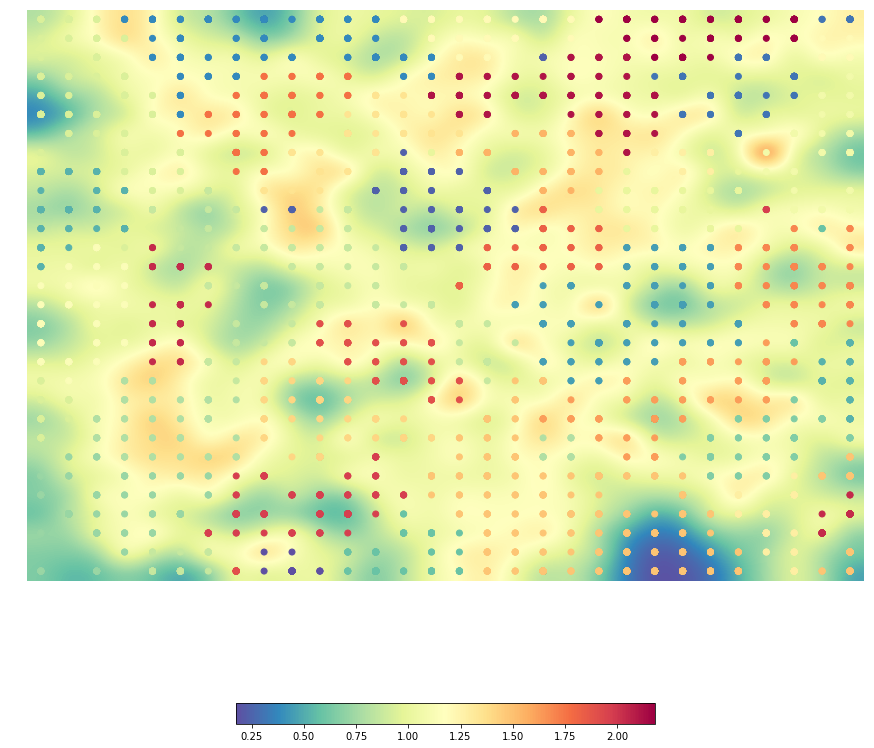

<module 'matplotlib.pyplot' from '/home/nbuser/anaconda2_501/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [20]:
algorithm = KMeans(30)#εφαρμόζουμε την δεύτερη μέθοδο clustering,Kmeans,δίνοντας τις κατάλληλες παραμέτρους
somKmeans=som.cluster(algorithm=algorithm)
som.view_umatrix(bestmatches=True,figsize=(15, 15),colorbar=True)

## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.

In [83]:
joblib.dump(som, 'som.pkl') 
joblib.dump(somKmeans, 'somKmeans.pkl') #αποθηκεύουμε το som


['somKmeans.pkl']

In [15]:
som = joblib.load('som.pkl')
somKmeans = joblib.load('somKmeans.pkl')

In [16]:
activation=som.get_surface_state()
best=som.get_bmus(activation_map=activation)
unique_bmus=np.unique(ar=best,return_index=True,axis=0)#βρίσκουμε τα μοναδικά best matching units

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">

In [17]:
print som.clusters#τυπώνουμε τον πίνακα που μας δείχνει σε ποιο cluster ανήκει κάθε νευρώνας
unique_clusters=np.unique(ar=som.clusters,return_counts=True)
indexes=np.argsort(unique_clusters[1])
print "Clusters sorted by increasing number of neurons:"
print "Cluster index",indexes#ο αριθμός του cluster
print "Number of Neurons",unique_clusters[1][indexes]#πλήθος νευρώνων ανά cluster

[[11 11 11  3  3  3  3  3  3  3  3  3  3 15 15 15 15 15 15 15 29 29 29 29
  29 29 29 29  2  2]
 [11 11 11 11  3  3  3  3  3  3  3  3  3  3 15 15 15 15 15 15 28 29 29 29
  29 29 29 29 15 15]
 [11 11 11 11  3  3  3  3  3  3  3  3  3  3  3 15 15 15  1 28 28 28 29 29
  29  2  2  2 15 15]
 [11 11 11 11 11  3  3  3 23 23 23 23  3  3  3 28 28 28 28 28 28 28  2  2
   2  2  2  2  2 13]
 [11 11 11 11 11  3  3 23 23 23 23 23 17 17 28 28 28 28 28 28 28 28 28  2
   2  2  2  2 13 13]
 [11 11 11 11 11  3 23 23 23 23 23 17 17 17 17 28 28 28 28 28 28 28 28  2
   2  2  2 13 13 13]
 [11 11 11 11 11 23 23 23 23 23 17 17 17 17 17 17 20 20 20 20 28 28 28  2
  16  2 13 13 13 13]
 [11 11 11 11 11 11 23 23 23 17 17 17 17  1 12 20 20 20 20 20 20 28 16 16
  16 16 13 13 13 13]
 [ 5  5  5 11 11 11 10 23 23 17 17 17  1  1  1  1 20 20 20 20 20 12 12 16
  16 12 13 13 13 13]
 [ 5  5  5  5 11 11 10 10 17 17 17  1  1  1  1  1  1 20 20 20 12 12 12 12
  12 12 12 13 13 13]
 [ 5  5  5  5 10 10 10 10  1  1 10 10  1  1  1  1 

## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα νευρώνα (μη βελτιστοποιημένος χάρτης):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
 

In [18]:
def print_categories_stats(movie_list):
    total_categories=[]#αρχικοποίηση λίστας που θα περιέχει όλες τις κατηγορίες,όσων ταινιών δόθηκαν
    for movie in movie_list:#για κάθε ταινία,στην λίστα που δόθηκε
        category=categories[movie]#βρίσκουμε κατηγορίες ταινίας
        categories_split=category[0].split(",")#σπάμε το string που περιέχει τις κατηγορίες και τις αποθηκεύουμε σε μία λίστα
        for i in range(len(categories_split)):#για κάθε κατηγορία
            categories_split[i]=categories_split[i].strip()#αφαιρούμε τα τυχόν κενά στην αρχή και το τέλος του string της κατηγορίας
        total_categories.extend(categories_split)#επεκτείνουμε τη λίστα των συνολικών κατηγοριών με την κάθε κατηγορία που βρίσκουμε
    unique_categ=np.unique(ar=total_categories,return_counts=True)#αφαιρούμε αντίγραφα και κρατάμε τις μοναδικές κατηγορίες
    indexes=(-unique_categ[1]).argsort()#τις διατάσσουμε σε φθίνουσα σειρά
    final=zip(unique_categ[0][indexes],unique_categ[1][indexes])#ενώνουμε κάθε κατηγοριά με την αντίστοιχο πλήθος ταινίων που την περιέχουν
    print final#το εκτυπώνουμε 
    return 0;


In [26]:
def neuron_movies_report(neuron_list):#δίνεται όρισμα μια λίστα νευρώνων
    movie_list=[]#αρχικοποίηση λίστας που θα περιέχει όλες τις ταινίες, που υπάρχουν στη λίστα των νευρώνων που δόθηκαν
    for neuron in neuron_list:#για κάθε νευρώνα της λίστας
        for i in range(len(best)):#διασχίζουμε όλο τον πίνακα best και βλέπουμε αν υπάρχει σε αυτόν ο νευρώνας της λίστας
            neuron1=np.asarray(neuron)
            subtr=np.subtract(best[i],neuron1)#αφαιρούμε από κάθε γραμμή του best τις συντεταγμένες του ζητούμενου νευρώνα
            if not any(subtr):#αν βρούμε ταινία που ανήκει σε αυτόν τον νευρώνα,κρατάμε το id της
                    movie_list.append(i)#στη λίστα movie_list
    print movie_list#εκτυπώνουμε την λίστα,καθώς μας βοήθησε στο debugging
    print_categories_stats(movie_list)#καλούμε την συνάρτηση,προκειμένου να δούμε για τους νευρώνες που δόθηκαν,όλες τις κατηγορίες που υπάρχουν σε αυτούς
    return 0;

In [29]:
def print_cluster_neurons_movies_report(cluster_num):
    neuron_list=[]#αρχικοποίηση λίστας που θα περιέχει όλες τους νευρώνες, που υπάρχουν στο cluster που δόθηκε
    ii=np.where(som.clusters==cluster_num)#βρίσκουμε τις συντεταγμένες του ζητούμενου cluster όπου υπάρχει στον som.clusters
    cord_clust=np.column_stack((ii[1],ii[0]))#τις αποθηκεύουμε μαζί
    #i som.clusters einai grammi stili
    #anazitisi tou cluster
    for cord in cord_clust:#για κάθε ζευγάρι συντεταγμένων 
        u=unique_bmus[:][0]#βλέπουμε αν το ζευγάρι των συντεταγμένων ανήκει στο bmus
        r0=u[:,0]#κρατάμε τη πρώτη στήλη
        r1=u[:,1]#κρατάμε τη δεύτερη στήλη
        indicesx = [i for i, x in enumerate(r0) if x ==cord[0]]#βλέπουμε που και αν υπάρχει η ζητούμενη πρώτη συντεταγμένη
        indicesy = [i for i, x in enumerate(r1) if x ==cord[1]]#βλέπουμε που και αν υπάρχει η ζητούμενη δεύτερη συντεταγμένη
        combo=list(set(indicesx).intersection(indicesy))#αν ναι,τότε αποθηκεύουμε τις συνταταγμένες του νευρώνα αυτού
        if combo:neuron_list.append(cord)
    neuron_movies_report(neuron_list)#καλούμε την προηγούμενη συνάρτηση,για όλα τα ζευγάρια νευρώνων,που ανήκουν στο cluster που δόθηκε
    return 0;

In [30]:
cluster=5
print_cluster_neurons_movies_report(cluster)

[129, 378, 1441, 1601, 2433, 2741, 2841, 2942, 3594, 3620, 3829, 4194, 4540, 4723, 4761, 100, 260, 503, 1199, 1446, 1578, 1779, 2449, 2618, 2672, 2945, 3037, 3476, 4102, 939, 1476, 3506, 3927, 4346, 4619, 2988, 2895, 3257, 4171, 1274, 1589, 1920, 2060, 2567, 314, 350, 732, 788, 1047, 1114, 1482, 1564, 1566, 1677, 1941, 2344, 2920, 3333, 3390, 3539, 3944, 4558, 4692, 4707, 4806, 391, 405, 430, 575, 684, 811, 1028, 1166, 1196, 1382, 1665, 1882, 1887, 2065, 2226, 2313, 2316, 2374, 2565, 2646, 2937, 3073, 3246, 3505, 3695, 3808, 4160, 4176, 4199, 4350, 4381, 4738, 4742, 4816, 708, 779, 1033, 1805, 2334, 2839, 2993, 4340, 4718, 4904, 1208, 2351, 2354, 3010, 1194, 3507, 4186, 4638, 287, 457, 531, 822, 1171, 1177, 1683, 1701, 2333, 2490, 3933, 4002, 4062, 4991, 88, 438, 574, 624, 1592, 2211, 2292, 2500, 3169, 3777, 4683, 4813, 4874, 617, 365, 1452, 1744, 1975, 1554, 1641, 2193, 3244, 3589, 3673, 3923, 4087, 4258, 4740, 3022, 3557, 825, 1477, 2503, 4207, 4698, 913, 971, 1410, 2319, 2934, 3067,

0

**Για SOM MAP :10x10,100 epochs στις 2000 ταινιες.**Παρατηρούμε ότι κάποια γειτονικά cluster είναι τα 3,6,16,17. Σε όλα αυτά εμφανίζεται ως κύρια κατηγορία η Drama, με δευτερεύουσες κατηγορίες να είναι το Crime Fiction,Comedy,War film.Άρα παρατηρούμε ότι κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Αν για τον ίδιο χάρτη δούμε clusters στην άλλη άκρη του χάρτη (συγκεκριμένα το cluster 8) παρατηρούμε κύρια κατηγορία το Comedy .Το cluster 8 είναι γειτονικό με τα cluster 1,15,7. Το 7 έχει και αυτό κύρια κατηγορία την Comedy. Ωστόσο το cluster 1 ,επειδή είναι και το μεγαλύτερο cluster και καταλαμβάνει μεγαλύτερο χώρο στο χάρτη δεν έχει σχέση με Comedy. Παρατηρούμε λοιπόν ότι τα cluster 7,8 που ειναι και σχετικά μικρά και ανεξάρτητα με τα υπόλοιπα γειτονικά τους τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη.

**Για SOM MAP :10x10,50 epochs στις 2000 ταινίες.** Τώρα ο χάρτης είναι προφανώς διαφορετικός από τον προηγούμενο. Τα clusters 5,8,10 είναι γειτονικά και όλα έχουν ως μια κύρια κατηγορία το Romance film και γενικά το Romance. Ως δεύτερη κύρια κατηγορία το ένα έχει Comedy,το άλλο Drama και το άλλο World Cinema. Άρα παρατηρούμε ότι είναι κοντινά σημασιολογικά cluster.
Στο κέντρο του χάρτη αυτού υπάρχει το μεγαλύτερο cluster 1,με γειτονικά τα 11,12,13. Το 1 έχει ταινίες με κοινό χαρακτηριστικό το Drama.Κάποιες από αυτές ανήκουν ταυτόχρονα και στην κατηγορία Thriller η War film ή Adventure ,που είναι και αυτές σημασιολογικά κοντινές κατηγορίες εν γένει. Το cluster 12 είναι πάλι κυρίως ταινίες με Drama, αλλα ταυτόχρονα και Romance Film (δηλαδή ναι μεν Drama αλλά σημασιολογικά διαφορετικό Drama από αυτό του cluster 1). Παρατηρούμε και εδώ μια γειτονική συνάφεια μεταξύ αυτών των 2 cluster. Τα άλλα δυο cluster που συνορεύουν με το 1, έχουν σε μικρό ποσοστό την κατηγορία Drama,και είναι κυρίως Silent film η μία και Family Film η άλλη. Δε βλέπουμε δηλαδή τόσο καλή σημασιολογική συγγένεια με το cluster 1. Τέλος παρατηρήσαμε και για το cluster 14 ότι είναι μικρό και απομακρυσμένο και ότι έχει μια σχετικά σπάνια κατηγορία ταινιών, το Black and white συνδυασμένο με το Comedy, συνδυασμός ο οποίος δεν υπάρχει πουθενά αλλού στο χάρτη.

Εν γένει μπορούμε να πούμε ότι τα αποτελέσματα για το μικρό dataset ήταν ικανοποιητικά τόσο για epochs=50 όσο και για epochs=100. Παρακάτω θα δοκιμάσουμε για το μικρό dataset να χρησιμοποιήσουμε μεγάλο χάρτη(διαστάσεων 20x20).

**Για SOM MAP:20x20,50 epochs,Kmeans=20 στις 2000 ταινίες.** Κατ'αρχάς τώρα βλέπουμε πιο ξεκάθαρο διαχωρισμό σε clusters στο umatrix. Σκοπός μας αρχικά είναι να κρίνουμε ποιο K είναι καλύτερο και αν χρειάζεται προσαρμογή. Στον χάρτη βλέπουμε στην κάτω δεξιά γωνία απομακρυσμένο το cluster 18, του οποίου το σημασιολογικό περιεχόμενο είναι το Black and White Comedy όπως και πριν.Γειτονικά cluster αυτού είναι το 5 και το 16. Το 5 είναι Comedy κυρίως και μικρό ποσοστό παρωδίας, άρα έχει συγγένεια με το 18. Το cluster 16 από την άλλη είναι τελείως διαφορετικό σημασιολογικά, καθώς είναι κυρίως Horror ταινίες με υποκατηγορίες τα Thriller,Science fiction και Slasher. Αυτά τα cluster που παρατηρήσαμε έως τώρα έχουν σαφές σημασιολογικό περιεχόμενο. Αυτό δεν ισχύει για το cluster 0 στον συγκεκριμένο χάρτη,το οποίο είναι και το μεγαλύτερο. Εδώ βλέπουμε κύριες κατηγορίες τελείως ανεξάρτητες μεταξύ τους, όπως π.χ Documentary,Silent Film,Science Fiction κλπ. Επίσης μέγιστο ποσοστό εμφάνισης των κατηγοριών αυτών είναι το 35, δηλαδή η περισσότερο εμφανιζόμενη κατηγορία εμφανίζεται σε 35 ταινίες, παρ'όλο που στο συγκεκριμένο cluster περιέχονται γύρω στις 200 ταινίες. Γενικά παρατηρήσαμε ότι όλα τα υπόποιπα cluster (πλην ίσως του cluster 10) είχαν πολύ καλά ορισμένο και διακριτό σημαασιολογικό περιεχόμενο. Επίσης, επειδή πάρα πολλές ταινίες ανήκαν στη κατηγορία του Drama, όπως και θα θέλαμε, αυτές έχουν χωριστεί σε cluster λαμβάνοντας υπ'όψιν τη δεύτερη και τρίτη κατηγορία της κάθε ταινίας, γιατί μια ταινία Drama μπορεί να είναι ταυτόχρονα Comedy,Romance,Thriller και παρατηρήσαμε γενικά ότι αυτός ο διαχωρισμός γίνεται επιτυχώς. Θα δοκιμάσουμε παρακάτω για Kmeans=30 για να δούμε αν εκεί αν όλα τα cluster είναι ικανοποιητικά.

**Για Kmeans=30** όλα τα clusters είχαν σαφή χαρακτηριστικά, εκτός από το 0,που ήταν και το μεγαλύτερο.Για αυτό το cluster όμως είδαμε ότι έχουν εισαχθεί ταινίες που είναι κάπως "περίεργες" και ξεχωριστές ως προς τις κατηγορίες τους,και δεν βρήκαν κάποιο καλύτερο ταίριασμα στα υπόλοιπα clusters. To cluster 9 ήταν Black and white Comedy και βρισκόταν παλι κατω δεξια. Είδαμε επίσης πολύ πιο έντονο το φαινόμενο γειτονικά cluster να έχουν παρεμφερή χαρακτηριστικά, αλλά είδαμε ότι γινόταν όλο και καλύτερη διάκριση. Για παράδειγμα ήταν 4 γειτονικά cluster με κύριο χαρακτηριστικό το Action ,και χωριστήκανε επειδή το ένα ήταν ταυτόχρονα και Drama,το άλλα Adventure,το άλλο Comedy. Με περαιτέρω αύξηση του Κ του Kmeans,ενδεχομένως να βελτιώσουμε το κακό cluster σπάζοντας το σε μικρότερα cluster, αλλά ταυτόχρονα ελλοχεύει ο κίνδυνος να χαλάσουμε τα υπόλοιπα.

**Για SOM MAP:20x20,100 epochs,Kmeans=20 στις 2000 ταινίες.** Παρατηρούμε,γενικά παρόμοια συμπεριφορά. Όλα τα clusters έχουν ξεκάθαρο σημασιολογικό περιεχόμενο,με τις 3 περίπου κυριάρχες κατηγορίες να αντιστοιχούν σε σχεδόν όλο το περιεχόμενο του εκάστοτε cluster. Εξαίρεση αποτελεί το cluster 10,το οποίο αν και έχει σύνολο 138 ταινίες, δεν υπάρχει κάποια κατηγορία που να σχετίζεται με την πλειονότητα των ταινιών.Συγκεκριμένα,οι πρώτες 6 κατηγορίες αναφερόνται σε 20 ταινίες η καθεμία. Αυτό αποτελέι κίνητρο για να δοκιμάσουμε να αυξήσουμε τον αριθμό των clusters.

**Για SOM MAP:20x20,100 epochs,Kmeans=30 στις 2000 ταινίες.** Παρατηρούμε ότι εξακολουθεί να υπάρχει cluster χωρίς ξεκάθαρο περιεχόμενο(το cluster 3), παρότι αυξήσαμε τον αριθμό Κ. Επιπρόσθετα, παρατηρούμε ότι δημιουργούνται clusters παρόμοιου περιεχομένου,που θα μπορούσαν κάλλιστα να είναι μαζί. Συγκεκριμένα, τα clusters 23,27,7,10,18 αναφέρονται όλα σε Thriller,έχουν συγκρίσιμο μέγεθος και οι νευρώνες τους είναι γειτονικοί στο som.clusters(ομοίως και για Romance). Επομένως, η αύξηση του Kmeans επέφερε αρνητικά αποτέλεσματα, χωρίς να συνεισφέρει αισθητά σε κάτι.Αυτό μας αποτρέπει από το να αυξήσουμε περαιτέρω την μεταβλητή Kmeans.

**Για SOM MAP:30x30,50 epochs,Kmeans=30 στις 5000 ταινίες.** Σε αυτή την περίπτωση εξακολουθούμε να παρατηρούμε ικανοποιητικά αποτελέσματα. Ενδιαφέρον παρουσιάζει η ύπαρξη ενός μεγάλου cluster(8) το οποίο έχει συλλέξει πολλές ταινίες, οι οποίες δεν πολυσχετίζονται μεταξύ τους. Πιθανόν περαιτέρω αύξηση του Kmeans να το διαχώριζε και να οδηγούσε σε καλύτερα αποτελέσματα. Ωστόσο, η ταυτόχρονη ύπαρξη μικρών cluster που παρουσιάζουν κοινό σημασιολογικό περιεχόμενο και βρίσκονται και  σε γειτονικούς νευρώνες(πχ 22-7 με κοινή θεματική ενότητα τα Family Films), υποδεικνύουν την ίσως υπερβολική αύξηση της παραμέτρου Kmeans, μιας και θα μπορούσαν να συμπτυχθούν. Παρόλα αυτά, είναι σημαντικό να αναφέρουμε ότι αυξάνοντας τον αριθμό των clusters,δίνεται η ευκαιρία να γίνει διαχωρισμός με βάση δευτερεύουσες κατηγορίες,γεγονός που μπορεί να οδηγήσει σε καλύτερα αποτελέσματα(πχ ο νευρώνας 14 σχετίζεται με το Drama και το Romance Film-Drama,ενώ ο νευρώνας 15 με το Drama,το Romance και το Comedy. Επομένως, δημιουργούνται υποκατηγορίες που μπορούν να οδηγήσουν σε καλύτερες προτεινόμενες ταινίες. 

**Για SOM MAP:30x30,100 epochs,Kmeans=30 στις 5000 ταινίες.** Σε αυτή την περίπτωση παρατηρούμε πιο ικανοποιητικά αποτελέσματα από ότι με 50 epochs. Υπάρχει και τώρα ένα cluster σαν το 8 πριν,που τώρα είναι το 10, το οποίο όμως τώρα έχει λιγότερες ταινίες από πριν(γύρω στις 400). Παρατηρούμε σε σχέση με πριν ότι δεν υπάρχουν πολύ μικρά cluster με πολυ λίγες ταινίες το καθένα, πράγμα που σημαίνει ότι έχει γίνει καλύτερος διαχωρισμός. Επίσης εξακολουθούμε να βλέπουμε όμοιες σημασιολογικά ταινίες σε συγγενικά σημεία του χάρτη. Ορισμένα παραδείγματα αυτού είναι τα cluster 5,6,21 που έχουν ως κύριες κατηγορίες τα Comedy,Drama,Romance και τις εναλλάσονται το καθένα ανά δύο. Άλλο ωραίο παράδειγμα είναι τα cluster 8,9 που είναι animation/Family Film/Adventures. Γενικά παρατηρούμε καλύτερη κατηγοριοποίηση σε σχέση με πριν και τα συγγενικά cluster έχουν έρθει πιο κοντά. Όσον αφορά τα clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές, ένα τέτοιο παράδειγμα είναι τα cluster 18 με 25, που το ένα αναφέρεται σε Documentary,ενώ το άλλο σε Comedy. Είναι λογικό να μην έχουν συνάφεια όλα τα cluster, γιατί κάπου πρέπει να σπάει η ομοιότητα, μιας και το φάσμα κατηγοριών ταινιών ποικίλλει και είναι τελείως διαφορετικό για διαφορετικές ομάδες ταινιών. Η τοπολογική συνάφεια με γειτονικές περιοχές εξαρτάται κιόλας από τις δευτερεύουσες κατηγορίες του κάθε cluster ,οι οποίες κάνουν μια επιπλέον διάκριση της πρωτεύουσας κατηγορίας, γιατί αυτή μπορεί να είναι λίγο γενική ή ασαφής (όπως π.χ η κατηγορία Drama ή Thriller ή Comedy). 
**Αυτός είναι και ο τελικός μας χάρτης τον οποίον και παραδώσαμε.**

**Συμπεράσματα σχετικά με τη πιθανότητα απεικόνισης δεδομένων του χώρου εισόδου σε περισσότερους νευρώνες.** Γενικά παρατηρήσαμε ότι κατηγορίες ταινιών όπως οι Drama,Romance Film,World Cinema,Thriller είναι οι συχνα εμφανιζόμενες στα δεδομένα εισόδου. Επίσης εμφανιζόντουσαν και στα περισσότερα cluster, που σημαίνει ότι είχαν απεικονιστεί με περισσότερους νευρώνες απότι άλλες κατηγορίες-δεδομένα, όπως π.χ τα Documentary,τα Japanese Movies,τα Family Films,τα Animations κλπ. Αυτό είναι λογικό,μιας και όπως παρατηρούμε παρακάτω,οι Drama,Comedy,Romance Film,Thriller,Action είναι οι κυριάρχες κατηγορίες στο dataset μας.

In [31]:
movie_list=range(5000)
print_categories_stats(movie_list)

[('"Drama"', 2292), ('"Comedy"', 1235), ('"Romance Film"', 799), ('"Thriller"', 763), ('"Action"', 672), ('"World cinema"', 598), ('"Crime Fiction"', 507), ('"Horror"', 491), ('"Black-and-white"', 463), ('"Short Film"', 414), ('"Indie"', 396), ('"Action/Adventure"', 394), ('"Family Film"', 384), ('"Adventure"', 382), ('"Romantic drama"', 293), ('"Animation"', 283), ('"Musical"', 282), ('"Mystery"', 270), ('"Science Fiction"', 268), ('"Romantic comedy"', 237), ('"Comedy film"', 233), ('"Fantasy"', 233), ('"Crime Thriller"', 199), ('"War film"', 191), ('"Period piece"', 161), ('"Silent film"', 155), ('"Film adaptation"', 154), ('"Japanese Movies"', 144), ('"Comedy-drama"', 143), ('"Psychological thriller"', 141), ('"Bollywood"', 141), ('"Documentary"', 131), ('"Chinese Movies"', 114), ('"Western"', 112), ('"Black comedy"', 98), ('"Family Drama"', 98), ('"Teen"', 97), ('"Parody"', 94), ('"Sports"', 93), ('"Martial Arts Film"', 85), ('"Suspense"', 79), ('"Television movie"', 79), ('"Childr

0

   
## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

# Τελική παράδοση άσκησης

- Θα παραδώσετε στο mycourses το παρόν notebook επεξεργασμένο με τις απαντήσεις σας (μπορείτε να κάνετε ένα αντίγραφο) για τα ζητούμενα και των δύο εφαρμογών. Προσέξτε να απαντήσετε σε όλα τα σημεία όπου απαιτείται.
- Μαζί Θα παραδώσετε τα joblib dumps των τελικών `corpus_tf_idf.pkl` και `som.pkl` (μεγάλος χάρτης - 5000 ταινίες) που θα χρησιμοποιήσετε.  
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στο dump του χάρτη που θα μας παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας.  
- Οδηγίες για την αποθήκευση των dumps θα βρείτε στο FAQ. 
- Μην ξεχάσετε στο τέλος ένα κελί markdown με τα στοιχεία της ομάδας σας.
- Και τα τρία αρχεία πρέπει να βρίσκονται σε ένα zip (ο χάρτης συμπιέζεται πολύ).

# Στοιχεία Ομάδας
## Ονοματεπώνυμα: Καρακάσης Χρυσόστομος(03113136),Γουρουνάς Δημήτρης(03113060)
## Αριθμός Ομάδας: Α18